In [1]:
import sys, os

import numpy as np
from umap import UMAP
import time
import matplotlib.pyplot as plt
import pandas as pd  
import scanpy as sc
import scipy.sparse as sps
import scipy.io as sio
# import scipy.sparse as sp
from os.path import join
import h5py
import warnings
import gc
from postp import HARMONY

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def wrap_warn_comp_plot(ads, basis, colors, figw=5, figh=4, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, color in enumerate(colors):
            _, axes = plt.subplots(1, len(ads), figsize=(figw*len(ads), figh))
            for j, ad in enumerate(ads):
                sc.pl.embedding(ad, basis=basis, color=color, ax=axes[j], show=False, **kwargs)
            plt.show()
            
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def load_h5(path):
    with h5py.File(path, 'r') as f:
        print(f['matrix'].keys())
        print(f['matrix']['features'].keys())

        barcodes = [_.decode('utf-8') for _ in f['matrix']['barcodes'][:]]
        data = f['matrix']['data'][:]
        indices = f['matrix']['indices'][:]
        indptr = f['matrix']['indptr'][:]
        shape = f['matrix']['shape'][:]

        feature_type = [_.decode('utf-8') for _ in f['matrix']['features']['feature_type'][:]]
        feature_id   = [_.decode('utf-8') for _ in f['matrix']['features']['id'][:]]
        feature_name = [_.decode('utf-8') for _ in f['matrix']['features']['name'][:]]
        feature_interval = [_.decode('utf-8') for _ in f['matrix']['features']['interval'][:]]


        X = sps.csc_matrix(
            (data, indices, indptr), 
            shape = shape
        ).tocsc().astype(np.float32).T.toarray()

        adata = sc.AnnData(X)
        adata.obs_names = barcodes
        adata.var_names = feature_id
        adata.var['type'] = feature_type
        adata.var['name'] = feature_name
        adata.var['interval'] = feature_interval
    return adata

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

def eval_ads(ads, ref_key, src_key):
    aris = []
    for ad in ads:
        aris.append(adjusted_rand_score(ad.obs[src_key], ad.obs[ref_key]))
    return aris

from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
def eval_labelTransfer(ad1, ad2, use_rep, lab_key, knn=10):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        neigh1 = KNeighborsClassifier(n_neighbors=knn)
        neigh1.fit(ad1.obsm[use_rep], ad1.obs[lab_key].to_list())
        pr_lab2 = neigh1.predict(ad2.obsm[use_rep])
        f1_1 = f1_score(ad2.obs[lab_key].values, pr_lab2, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        # acc1 = (pr_lab2 == ad2.obs[lab_key].values).mean()
    
        neigh2 = KNeighborsClassifier(n_neighbors=knn)
        neigh2.fit(ad2.obsm[use_rep], ad2.obs[lab_key].to_list())
        pr_lab1 = neigh2.predict(ad1.obsm[use_rep])
        # acc2 = (pr_lab1 == ad1.obs[lab_key].values).mean()
        f1_2 = f1_score(ad1.obs[lab_key].values, pr_lab1, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        return (f1_1+f1_2)/2


In [3]:
def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v
    
def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def set_spatial(ad):
    ad.obsm['spatial'] = ad.obs[['array_row', 'array_col']].values
    ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]
    ad.obsm['spatial'][:, 1] = -1 * ad.obsm['spatial'][:, 1]
    return ad

### load metadata

In [4]:
data_dir = '/disco_500t/xuhua/data/MISAR_seq/BaiduDisk/'

meta_data = pd.read_csv(join(data_dir, 'section1/meta_data.csv'), index_col=0)

In [5]:
df = pd.read_csv('./outputs/E15-13-18_Npeak=20000.csv', index_col=0)
new_ind = []
for ind in df.index:
    if ind.startswith('rna'):
        new_ind.append(ind.split('rna_')[1])
    elif ind.startswith('atac_'):
        new_ind.append(ind.split('atac_')[1])
    else:
        new_ind.append(ind)
df.index = new_ind

In [6]:
bridge_names = [_ for _ in df.index if _.startswith('E15')]
test_13_names = [_ for _ in df.index if _.startswith('E13')]
test_18_names = [_ for _ in df.index if _.startswith('E18')]

In [20]:
ad_bridge = sc.AnnData(df.loc[bridge_names], obsm={'emb': df.loc[bridge_names].values}, obs=meta_data.loc[bridge_names].copy())
ad_test_rna = sc.AnnData(df.loc[test_13_names], obsm={'emb': df.loc[test_13_names].values}, obs=meta_data.loc[test_13_names].copy())
ad_test_atac = sc.AnnData(df.loc[test_18_names], obsm={'emb': df.loc[test_18_names].values}, obs=meta_data.loc[test_18_names].copy())

In [21]:
ad_bridge = set_spatial(ad_bridge)
ad_test_rna = set_spatial(ad_test_rna)
ad_test_atac = set_spatial(ad_test_atac)

### before harmony

In [30]:
ad_mosaic = sc.concat([ad_bridge, ad_test_rna, ad_test_atac], label='src', keys=['E15', 'E13', 'E18'])
ad_mosaic = get_umap(ad_mosaic, ['emb'])

try:
    
    # from sklearn.cluster import KMeans
    # print("mclust failed, try louvain")
    # kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['emb'])
    # ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
    # clust_key = 'kmeans'

    ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='emb')  
    clust_key = 'mclust'
   
except:

    # ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='emb')  
    # clust_key = 'mclust'
    print('mclust failed')
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['emb'])
    ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
    clust_key = 'kmeans'
    
split_ob([ad_bridge, ad_test_rna, ad_test_atac], ad_mosaic, ob='obs',  key=clust_key)

fitting ...
  |                                                                      |   0%

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%
mclust failed


In [31]:
ad_mosaic.obs['before_clust'] = ad_mosaic.obs[clust_key].to_list()

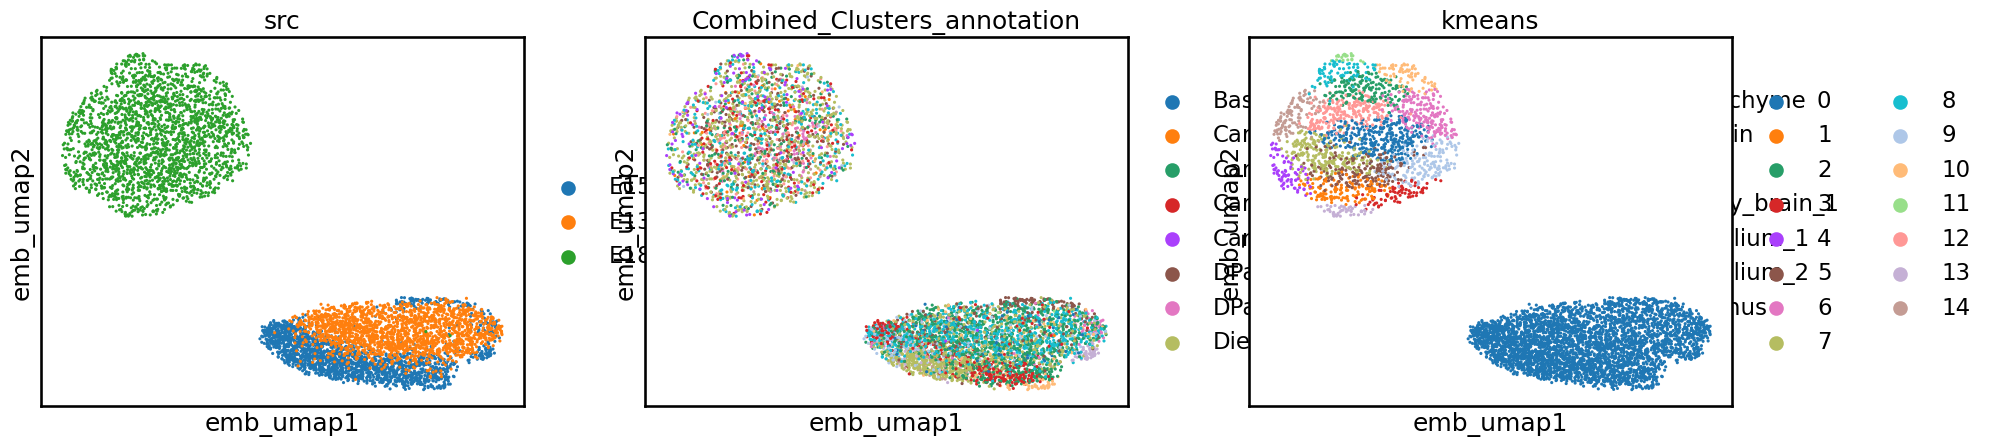

In [32]:
wrap_warn_plot(ad_mosaic, 'emb_umap', ['src', 'Combined_Clusters_annotation', clust_key])

In [10]:
### evaluation
from sklearn.metrics import adjusted_rand_score

r1 = eval_ads([ad_mosaic, ad_bridge, ad_test_rna, ad_test_atac], 'Combined_Clusters_annotation', clust_key)
r1

# 20000
# [0.009691604672676287, 0.0, 0.0, -0.0005921776989249601]

[0.009691604672676287, 0.0, 0.0, -0.0005921776989249601]

In [11]:
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='emb', use_neighbors=False,
)
lisi_res['src_iLISI'][0]

# 20000
# 0.06749393148045368

0.06749393148045368

In [12]:
r4 = eval_labelTransfer(ad_test_rna, ad_test_atac, 'emb', 'Combined_Clusters_annotation', knn=10)
r4

# 20000
# 0.018580756809633645

0.018580756809633645

## after harmony

In [33]:
from postp import HARMONY

ad_mosaic.obsm['emb_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['emb']), ad_mosaic.obs.src.values)
ad_mosaic = get_umap(ad_mosaic, ['emb_har'])
split_ob([ad_bridge, ad_test_rna, ad_test_atac], ad_mosaic, ob='obsm',  key='emb_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
Reach convergence after 4 iteration(s).


In [47]:
try:

    # ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='emb_har')  
    # clust_key = 'mclust'
    # mclust 跑不出来15个簇
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['emb_har'])
    ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
    clust_key = 'kmeans'
   
except:

    # ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='emb_har')  
    # clust_key = 'mclust'

    from sklearn.cluster import KMeans
    print("mclust failed, try kmeans")
    kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['emb_har'])
    ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
    clust_key = 'kmeans'
    
split_ob([ad_bridge, ad_test_rna, ad_test_atac], ad_mosaic, ob='obs',  key=clust_key)

In [48]:
ad_mosaic.obs['after_clust'] = ad_mosaic.obs[clust_key].to_list()

In [15]:
### evaluation
from sklearn.metrics import adjusted_rand_score

r1 = eval_ads([ad_mosaic, ad_bridge, ad_test_rna, ad_test_atac], 'Combined_Clusters_annotation', clust_key)

lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='emb_har', use_neighbors=False,
)
r2 = lisi_res['src_iLISI'][0]

r4 = eval_labelTransfer(ad_test_rna, ad_test_atac, 'emb_har', 'Combined_Clusters_annotation', knn=10)

In [16]:
r1, r2, r4

([0.01544783238129329,
  0.052907981738368505,
  -0.003343336290958509,
  -0.006159493237663189],
 0.19570286952727922,
 0.03430049632447366)

### Vis

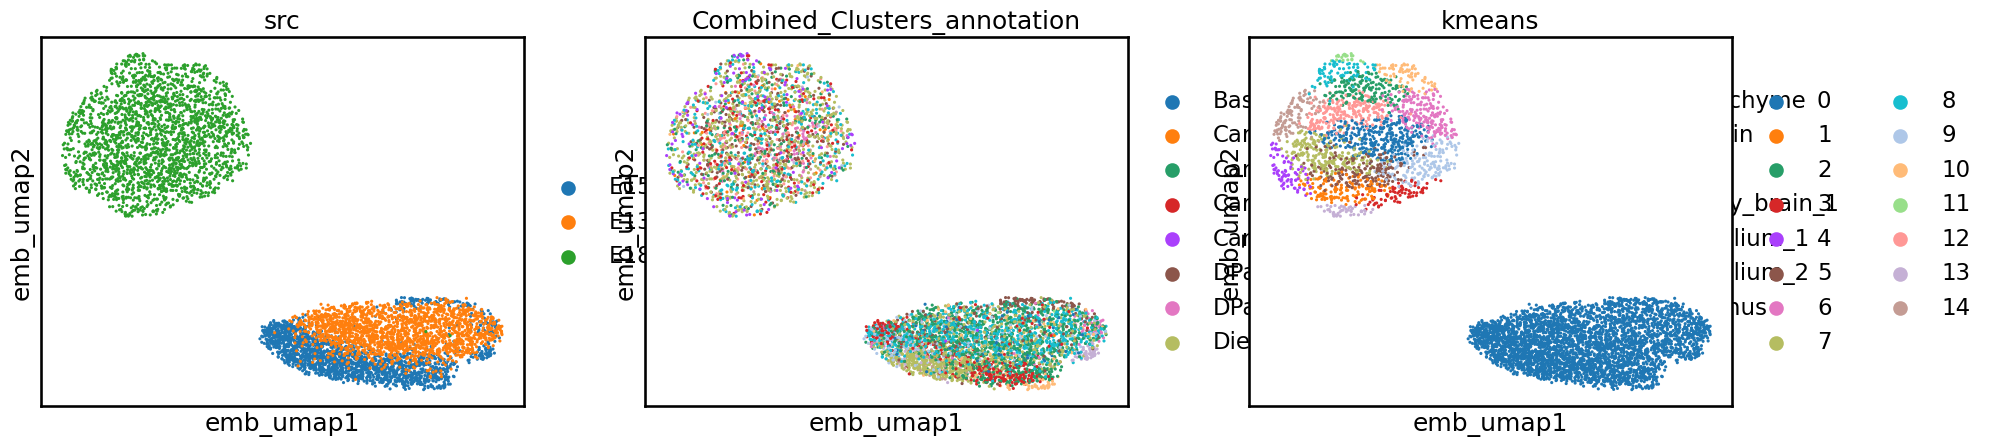

In [26]:
wrap_warn_plot(ad_mosaic, 'emb_umap', ['src', 'Combined_Clusters_annotation', clust_key])

# unify type colors
mclust_type2dict = dict(zip(ad_mosaic.obs[clust_key].cat.categories, ad_mosaic.uns[f'{clust_key}_colors']))
label_type2dict = dict(zip(ad_mosaic.obs.Combined_Clusters_annotation.cat.categories, ad_mosaic.uns['Combined_Clusters_annotation_colors']))
ad_bridge, ad_test_rna, ad_test_atac = unify_colors(
    [ad_bridge, ad_test_rna, ad_test_atac], clust_key, mclust_type2dict)
ad_bridge, ad_test_rna, ad_test_atac = unify_colors(
    [ad_bridge, ad_test_rna, ad_test_atac], 'Combined_Clusters_annotation', label_type2dict)

In [51]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/misar_seq/E15-13-18/stabmap'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['emb'], index=ad_bridge.obs_names.to_list() + ad_test_rna.obs_names.to_list() + ad_test_atac.obs_names.to_list())
df['before_clust'] = ad_mosaic.obs['before_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['emb_har'], index=ad_bridge.obs_names.to_list() + ad_test_rna.obs_names.to_list() + ad_test_atac.obs_names.to_list())
df['after_clust'] = ad_mosaic.obs['after_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb_har.csv'))